In [1]:
%matplotlib inline

In [17]:
import json
import pylab
import numpy as np
import pandas as pd
from dateutil.parser import parse
from matplotlib.dates import date2num
from pysurvey.plot import setup, icolorbar, dateticks

In [4]:
out = []
with open('/Users/ajmendez/data/smartmeter/scmp.1453299403.2016.01.20.json', 'r') as f:
    for line in f.readlines():
        if "Time" in line:
            out.append(json.loads(line))

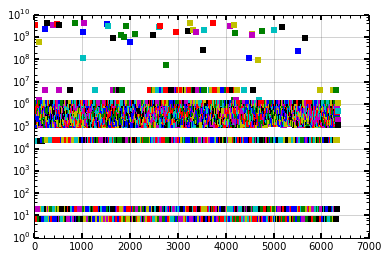

In [5]:
setup(ylog=True, xlog=False)
for i, item in enumerate(out):
    msg = item['Message']
#     print msg['EndpointID']
    pylab.plot(i, msg['Consumption'], 's', lw=0, markeredgecolor='none')

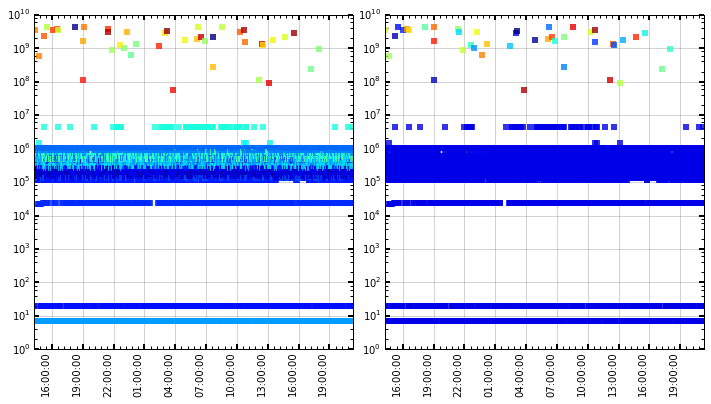

In [10]:
tmp = [item['Message']['EndpointID'] for item in out]
utmp = np.unique(tmp)
protocol = sorted(np.unique([item['Message']['ProtocolID'] for item in out]))
colors = {x:pylab.cm.jet(i*1.0/len(utmp)) for i,x in enumerate(utmp)}
protocol_colors = {x:pylab.cm.jet(i*1.0/len(protocol)) for i,x in enumerate(protocol)}

ax = setup(figsize=(12,6), subplt=(1,2,1), ylog=True)
ax2= setup(subplt=(1,2,2), ylog=True)
for i, item in enumerate(out):
    msg = item['Message']
    tmp = parse(item['Time'])
    color = colors[msg['EndpointID']]
    ax.plot(tmp, msg['Consumption'], 's', color=color, 
               lw=0, alpha=0.8, markeredgecolor='none',markeredgewidth=0)
    
    color = protocol_colors[msg['ProtocolID']]
    ax2.plot(tmp, msg['Consumption'], 's', color=color, 
             lw=0, alpha=0.8, markeredgecolor='none',markeredgewidth=0)
for a in [ax,ax2]:
    pylab.sca(a)
    dateticks('%H:%M:%S', rotation=90)

In [11]:
print 'Found {} meters. {} protocols'.format(len(utmp), len(protocol))

Found 79 meters. 44 protocols


In [51]:
dtype = [(None, 'index', np.int),
         ('Time', 'date', np.float),
         ('Hour', 'hour', np.float),
         ('EndpointID', 'endpoint', np.int64),
         ('ProtocolID','protocol', np.int),
         ('Consumption', 'consume', np.int),
         ('EndpointType','type', np.int),
         ('FrameSync','sync', np.int),
         ('PacketCRC','crc', np.int),
         ('Tamper','tamper', np.int),
        ]
data = np.zeros(len(out), dtype=[(b,c) for a,b,c in dtype])
for i, item in enumerate(out):
    for intag, outtag, _ in dtype:
        if outtag  == 'date':
            data[outtag][i] = date2num(parse(item[intag]))
        elif outtag == 'hour':
            data[outtag][i] = ((data['date'][i] - 5.0/24)%1)*24
        elif outtag == 'index':
            data[outtag][i] = i
        else:
            data[outtag][i] = item['Message'][intag]

In [87]:
endpoints = sorted(np.unique(data['endpoint']))
for i, endpoint in enumerate(endpoints):
    ii = np.where(data['endpoint'] == endpoint)[0]
    if len(ii) <= 1: continue
#     print '{: 3d} {:03d} {: 8d} {: 3d} {: 3d}'.format(i, len(ii), endpoint, np.unique(data['protocol'][ii])[0], np.unique(data['type'][ii])[0])

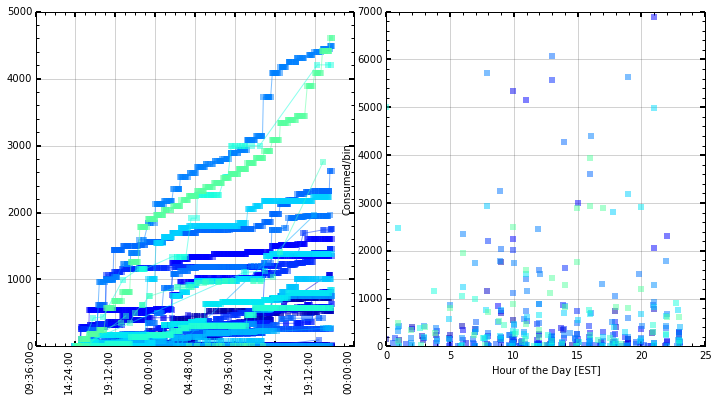

In [89]:
endpoints = sorted(np.unique(data['endpoint']))
protocol = sorted(np.unique(data['protocol']))
colors = {x:pylab.cm.jet(i*1.0/len(endpoints)) for i,x in enumerate(endpoints)}
protocol_colors = {x:pylab.cm.jet(i*1.0/len(protocol)) for i,x in enumerate(protocol)}

setup(figsize=(12,6), subplt=(1,2,1))
for i, endpoint in enumerate(endpoints):
    ii = np.where(data['endpoint'] == endpoint)[0]
    if len(ii) <= 1:
        continue
    minval = np.nanmin(data['consume'][ii])
    assert len(np.unique(data['protocol'][ii]))== 1, 'Found multiple protocols for a given endpoint!' 
    pylab.plot(data['date'][ii], data['consume'][ii] - minval, '-s', 
               color=colors[endpoint], markeredgecolor='none', alpha=0.5)
dateticks('%H:%M:%S', rotation=90)

setup(subplt=(1,2,2), xlabel='Hour of the Day [EST]', ylabel='Consumed/bin')
consume_hour = []
consume_val  = []
for i, endpoint in enumerate(endpoints):
    ii = np.where(data['endpoint'] == endpoint)[0]
    if len(ii) <= 1:
        continue
    starthour = data['hour'][ii][:-1]
    consumed = np.diff(data['consume'][ii]) / np.diff(data['hour'][ii])
    jj = np.where(consumed > 0)[0]
    consume_hour.extend(starthour[jj])
    consume_val.extend(consumed[jj])
    
    pylab.plot(starthour[jj], consumed[jj], 's',
               color=colors[endpoint],
               markeredgecolor='none', alpha=0.5)

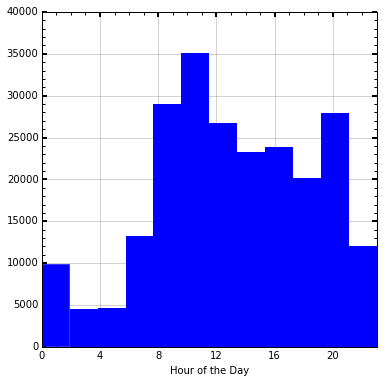

In [90]:
setup(figsize=(6,6), xtickv=np.arange(0,25,4), xlabel='Hour of the Day')
_ = pylab.hist(consume_hour, weights=consume_val, bins=12, lw=0)

In [49]:
print item['Time'], parse(item['Time']), (date2num(parse(item['Time']))%1)*24

2016-01-21T16:19:01.293101774-05:00 2016-01-21 16:19:01.293101-05:00 21.3170258626
